In [2]:
# Third-party
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from pyia import GaiaData

In [30]:
R0 = 8.3*u.kpc
gc_frame = coord.Galactocentric(z_sun=0*u.pc, galcen_distance=R0)

In [105]:
# see FGK-select.ipynb
# stype = 'fgk'
stype = 'af'

if stype == 'af':
    vmax = 1E2
    hex_h = 150 # pc
    
elif stype == 'fgk':
    vmax = 3e2
    hex_h = 120

g = GaiaData('../data/{0}.fits'.format(stype))

c = g.skycoord
galcen = c.transform_to(gc_frame)

In [106]:
gal = c.galactic
gal.set_representation_cls('cartesian')

---

## Hexagons

In [107]:
def get_hexagons(h):
    a = np.sqrt(3)/2 * h # inner side
    
    pas = dict() # keyed by "ring"
    pas[0] = list()
    pas[1] = list()
    pas[2] = list()
    
    pa0 = mpl.patches.RegularPolygon((0., 0.), numVertices=6, 
                                     radius=h, orientation=np.pi/2)
    pas[0].append(pa0.get_verts())

    for ang in np.arange(0, 360, 60)*u.deg:
        # Ring 1
        xy0 = 2*a * np.array([np.cos(ang+90*u.deg), np.sin(ang+90*u.deg)])
        pa = mpl.patches.RegularPolygon(xy0, numVertices=6, 
                                        radius=h, orientation=np.pi/2)
        pas[1].append(pa.get_verts())
        
        # Ring 2
        xy0 = 4*a * np.array([np.cos(ang+90*u.deg), np.sin(ang+90*u.deg)])
        pa = mpl.patches.RegularPolygon(xy0, numVertices=6, 
                                        radius=h, orientation=np.pi/2)
        pas[2].append(pa.get_verts())
        
        xy0 = 3*h * np.array([np.cos(ang+120*u.deg), np.sin(ang+120*u.deg)])
        pa = mpl.patches.RegularPolygon(xy0, numVertices=6, 
                                        radius=h, orientation=np.pi/2)
        pas[2].append(pa.get_verts())
        
    return pas

In [109]:
hexs = get_hexagons(hex_h)

Text(0,0.5,'$y$ [pc]')

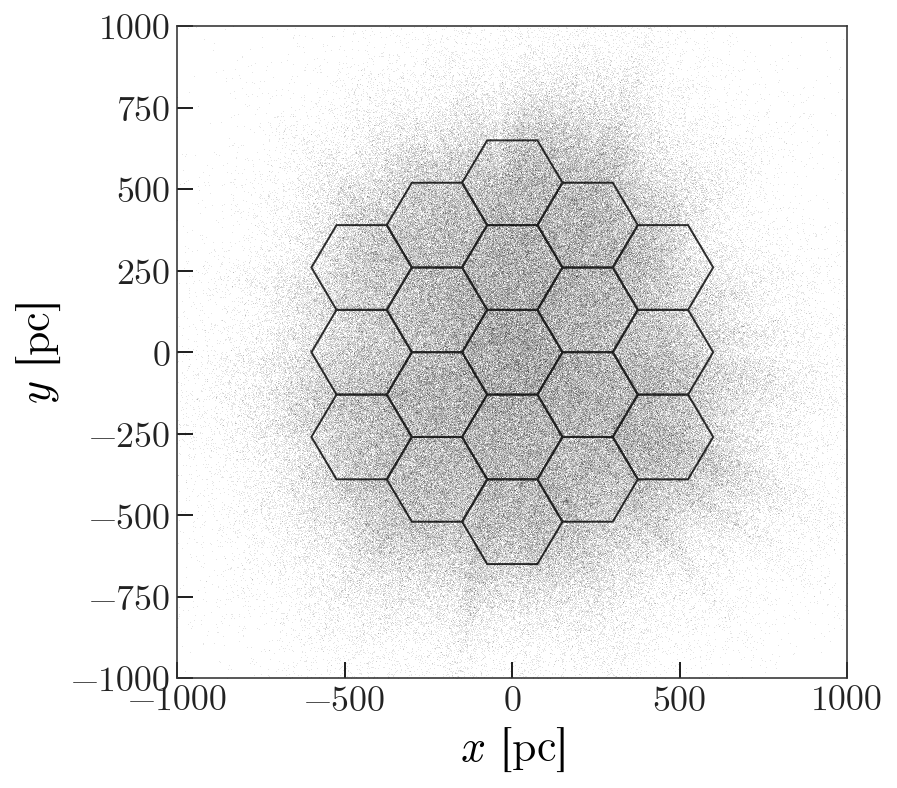

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for k in hexs.keys():
    for pa in hexs[k]:
        pa = mpl.patches.Polygon(pa, facecolor='none', edgecolor='#333333')
        ax.add_patch(pa)

        
ax.plot(gal.u, gal.v,
        marker=',', alpha=0.1, color='k',
        linestyle='none', zorder=100)
        
lim = 1000
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

ax.set_xlabel('$x$ [pc]')
ax.set_ylabel('$y$ [pc]')

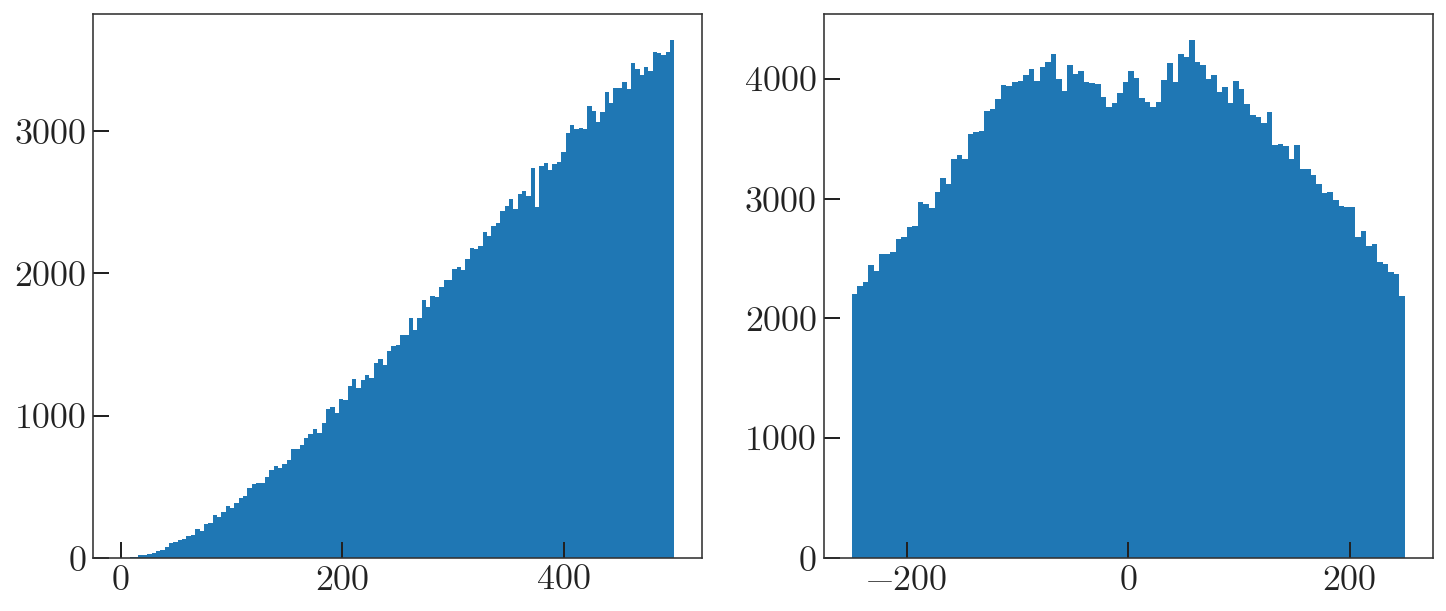

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(c.distance.value, bins=np.linspace(0, 500, 128));
axes[1].hist(gal.w.value, bins=np.linspace(-250, 250, 101));

---

In [112]:
cyl = gal.transform_to(gc_frame)
cyl.set_representation_cls('cylindrical')

xyz = np.vstack((gal.u.to(u.pc).value, 
                 gal.v.to(u.pc).value,
                 gal.w.to(u.pc).value)).T

UVW = np.vstack((cyl.d_rho.to(u.km/u.s).value, 
                 (cyl.rho * cyl.d_phi).to(u.km/u.s, u.dimensionless_angles()).value, 
                 cyl.d_z.to(u.km/u.s).value)).T

In [113]:
# testing
hex_mask = mpl.patches.Path(hexs[0][0]).contains_points(xyz[:, :2])

In [114]:
from scipy.stats import binned_statistic

(-10, 10)

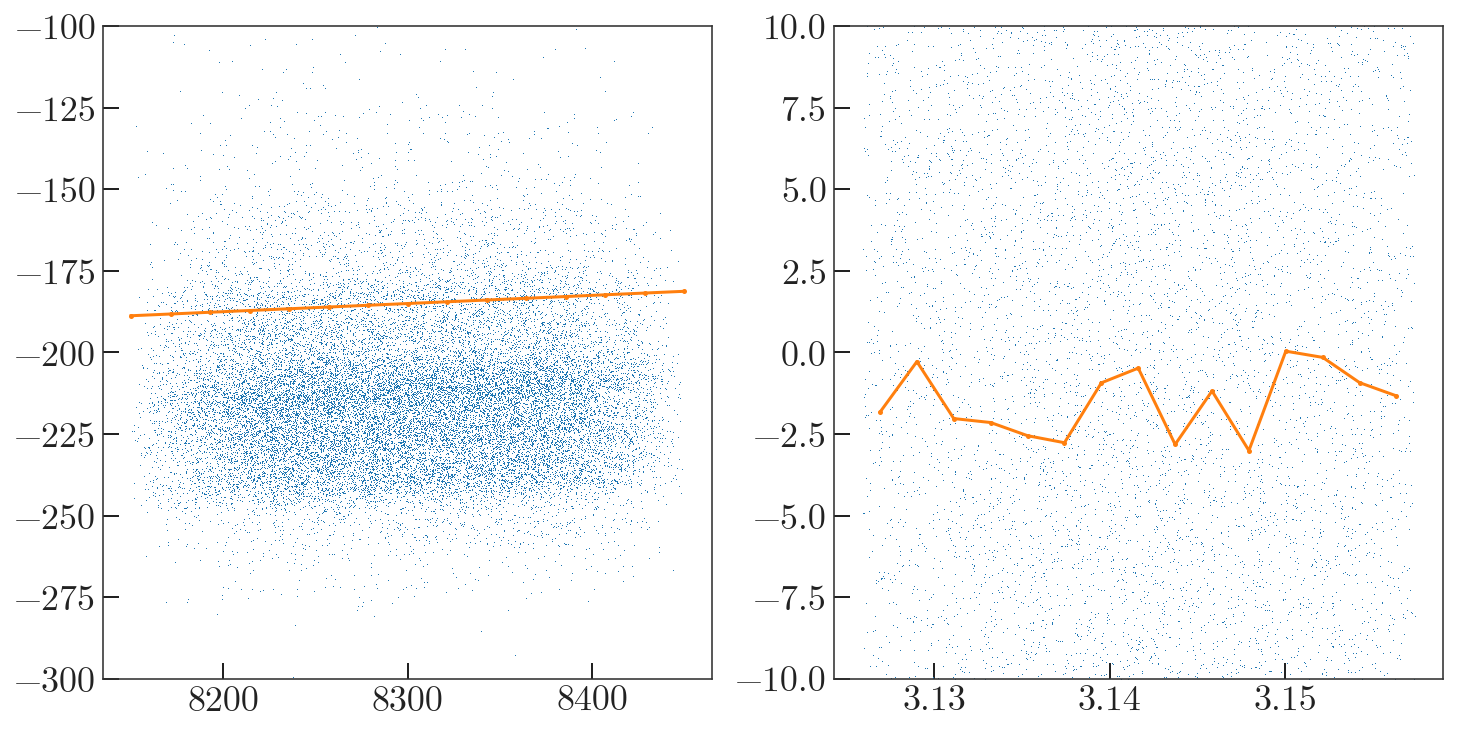

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

_rho = cyl.rho.value[hex_mask]
axes[0].plot(_rho, UVW[hex_mask, 1],
             marker=',', linestyle='none')
# stat = binned_statistic(_rho, UVW[hex_mask, 1], 
#                         bins=np.linspace(_rho.min(), _rho.max(), 16), 
#                         statistic='mean')
# axes[0].plot(0.5*(stat.bin_edges[:-1]+stat.bin_edges[1:]), stat.statistic)
xx = np.linspace(8150, 8450, 15)
axes[0].plot(xx, 5/200 * (xx - 8300) - 185)
axes[0].set_ylim(-300, -100)

_phi = cyl.phi.wrap_at(2*np.pi*u.radian).radian[hex_mask]
axes[1].plot(_phi, UVW[hex_mask, 0],
             marker=',', linestyle='none')

stat = binned_statistic(_phi, UVW[hex_mask, 0], 
                        bins=np.linspace(_phi.min(), _phi.max(), 16), 
                        statistic='mean')
axes[1].plot(0.5*(stat.bin_edges[:-1]+stat.bin_edges[1:]), stat.statistic)
axes[1].set_ylim(-10, 10)

Bovy: A = ~15, B = ~-11

In [116]:
dVphi_dR = 5*u.km/u.s / (200*u.pc)
# dVR_dphi = -2*u.km/u.s / (0.02*u.radian)
dVR_dphi = np.polyfit(0.5*(stat.bin_edges[:-1]+stat.bin_edges[1:]), 
                      stat.statistic, deg=1)[-1] * u.km/u.s / u.radian

_R = cyl.rho.value[hex_mask]
statR = binned_statistic(_R, UVW[hex_mask, 0], 
                         bins=np.linspace(_R.min(), _R.max(), 16), 
                         statistic='mean')
dVR_dR = np.polyfit(0.5*(statR.bin_edges[:-1]+statR.bin_edges[1:]), 
                    statR.statistic, deg=1)[-1] * u.km/u.s / u.kpc

statphi = binned_statistic(_phi, UVW[hex_mask, 1], 
                           bins=np.linspace(_phi.min(), _phi.max(), 16), 
                           statistic='mean')
dVphi_dphi = np.polyfit(0.5*(statphi.bin_edges[:-1]+statphi.bin_edges[1:]), 
                        statphi.statistic, deg=1)[-1] * u.km/u.s / u.radian

# - sign's on A,B because phi increases opposite way as Oort defines!
with u.set_enabled_equivalencies(u.dimensionless_angles()):
    A = -0.5 * (np.mean(UVW[hex_mask, 1])*u.km/u.s / R0 - dVphi_dR - dVR_dphi/R0)
    B = -0.5 * (-np.mean(UVW[hex_mask, 1])*u.km/u.s / R0 - dVphi_dR + dVR_dphi/R0)
    C = 0.5 * (-np.mean(UVW[hex_mask, 0])*u.km/u.s / R0 + dVR_dR - dVphi_dphi/R0)
    D = 0.5 * (np.mean(UVW[hex_mask, 0])*u.km/u.s / R0 + dVR_dR + dVphi_dphi/R0)

In [117]:
A

<Quantity 19.59453475 km / (kpc s)>

In [118]:
B

<Quantity 5.40546525 km / (kpc s)>

In [119]:
C

<Quantity 3.17758616 km / (kpc s)>

In [120]:
D

<Quantity -30.98478169 km / (kpc s)>